In [8]:
# Check out the library module "uwavy.py" for more details
from uwavy import *

# UWavy Navigation - Solution

1. [Overview](#Overview)
2. [Inertial Navigation](#Inertial-Navigation)
3. [Image Recognition](#Image-Recognition)
4. [Synthesis](#Synthesis)
5. [Conclusion](#Conclusion)

## Overview



Our goal was to generate a robust navigation system that is capable of operataing without any communication with a secondary system. Specifically, we wanted to eliminate the use of all signals inclueding GPS, cellular and wifi, as using signals inherently puts the navigation system at risk. Signals can be intercepted: providing adversaries intelligence, blocked: disabling your system entirely or spoofed: allowing adversaries to manipulate your system. 

Our solution was to combine two navigation systems that are partially effective on their own. The first is Inertial Navigation, which utilizes accelerometers to constantly measure the velocity and acceleration of the unit, and continuously update it's position. The other is image recognition. In order for this system to function, we require that the drone has a database of satellite images and their respective coordinates. Then using computer vision, we can match the drone's current view to the satellite image.



## Inertial Navigation

### Generating a "True" Path

Our coordinate system used in this simulation is simply the pixel grid of the reference image. This will be discussed in more detail in the image recognition section, but the inertial navigation system uses the same coordinates for simplicity. This coordinate system could be scaled or shifted linearly in any direction and with any magnitude, and our system would not be affected. The pixel grid was simply chosen for simplicity.

The paths used by our simulation are generated by first generating an array of changes in displacement. We chose this method because it allows us to easily add systematic error to our simulation of the inertial measurement unit. In addition, is easy to construct complex shapes and paths with this method, because the changes in position will be constant, regardless of the absolute position of the drone.



In [9]:
# Set out a path, starting at START_POS and following updates along DELTAS_TRUE
start_pos = np.array([[1500,850]])
deltas_true = -(np.vstack((-wide_uturn(3), np.vstack([s_turn(1) for _ in range(3)]))) * 60).astype(np.float64)
path_true = np.cumsum(np.vstack((start_pos, deltas_true)), axis=0)



### Introducing Systematic and Random Error

From our research of Inertial Measurement Units, we decided that there were two  types of errors that we wanted to simulate in order to faithfully simulate an actual IMU.
1. The first type of error is systematic error, which would stem from the calibration of the unit not being accurate. For example, this could mean that the unit consistently measures that its momentum to the northeast is higher than it actually is, meaning its measured position is consistently more to the northeast. We simulate this by adding a constant error to every delta in the array. This error is usually small on a millitary quality drone, but over long periods of time, this type of error will invevitably show up. We tried to make our simulated error larger than we expect in practice.
2. The other type of error is random error. This type of error would stem from the uncertainty of the unit. IMUs cannot have infinite precision, and so there will be some uncertainty. Like systemic error, on millitary quality drones, this will be small, but on long flights this error will compound. We simulated this error by adding a random error generated from a gaussian distribution

In [10]:
# Add systematically biased error 
deltas_IMU = (deltas_true - np.array([3, -1])).astype(np.float64)
#Add random error
deltas_IMU = (deltas_IMU - np.random.random_sample(deltas_true.shape))

path_IMU = np.cumsum(np.vstack((start_pos, deltas_IMU)), axis=0)

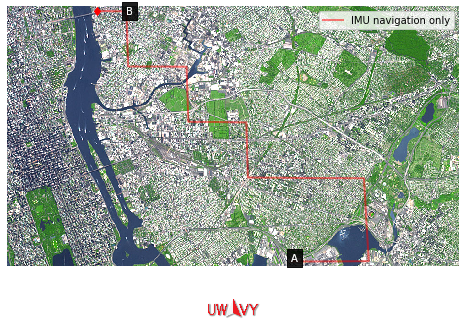

In [11]:
ani = FlightAnimator(framerate=500)
ani.add_start(start_pos[0])
ani.add_end(path_true[-1])
ani.add_path(path_IMU, label="IMU navigation only", color="red")
aniobj = ani.save('README_files/IMUonly.mp4')
HTML(ani.toHTML5Video())


If you can't see the video in your browser, [click here](./README_files/IMUonly.mp4)

## Image Recognition
As can be seen above, inertial navigation on its own is not very impressive, but combining it with images taken from a drone's onboard camera can yield exceptional results. This section explains how the image recognition part of the software works by examining some of the underlying algorithms and walking through a simple demo.


### Simulating the image database

In practive, a drone will use its onboard camera to take an image of the ground. This image must be matched with a reference image whose location is already known. A match indicates that the position of the drone is the same as the position of the reference image.

We simulate this process using a single reference image. In practice, we could have many images, layered on top of each other and stiched together, but this most basic MVP serves as a compelling proof of concept. Our reference image—seen below—is a [map of New York City](https://en.wikipedia.org/wiki/File:Aster_newyorkcity_lrg.jpg) comprising all five boroughs with a resolution of 5,125 pixels per square kilometer. Future iterations will use multiple such images stiched together, but this should work fairly well for navigation about a single city such as New York. 

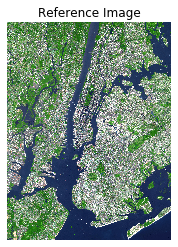

In [12]:
plot_ref_img();

### Simulating the onboard camera
In the real world, a drone will use its onboard camera to capture an image of the ground directly beneath it. The area of terrain captured will depend on the focal length of the camera, which is known beforehand, and the altitude of the drone, which can be measured in real time. Thus, the image captured will be a rectangle — we chose to model it as a square for simplicity — with the drone's actual location at the center. 

This definition allows a straightforward simulation of the drone's onboard camera. "Taking a picture" in the simulation just means taking a slice of the reference image of a given size with the drone's true position — which is known exactly in the simulation — at the center. This of course does not account for changes in lighting, shadows or other movable objects, but we found we achieved promising results that validated our MVP with just this simple model. 

A function to simulate taking a picture from the drone's camera could look something like this (see [library module](./uwavy.py) for more detail):
```python
def take_picture(img, pos, radius):
    return img[pos.x - radius : pos.x + radius, pos.y - radius : pos.y + radius]
```

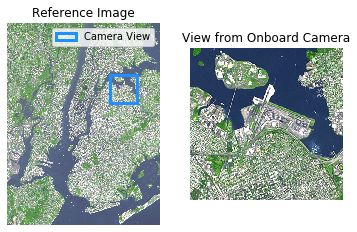

In [13]:
pos = np.array((850,1500))

ax = plt.subplot(1,2,1)
plot_ref_img(ax, pos)

img = take_picture(pos)

plt.subplot(1,2,2)
plt.imshow(img)
plt.title("View from Onboard Camera")
plt.axis('off');

### Comparing the captured image with the database
To determine if the drone is in a particular location, we compare the image taken by the drone's camera with identically sized slices from the reference image. When the two images match, we know that the drone must be at the exact center of the matching slice. We define a straightforward algorithm for matching image slices: compare each pixel value for value and take the mean squared error, i.e.
```python
error = np.sum(np.square(test_slice - ref_slice)) / num_pixels
```
where test_slice is the image captured from the camera and ref_slice is a slice from the database.

The graphic below demonstrates the result of searching across a horizontal line spanning the width of the image. The red line plots the result of the error function above as the test_slice slides across the line. As you can see, the minimum error occurs when the center of the test slice is at the actual position of the drone, indicating a match.

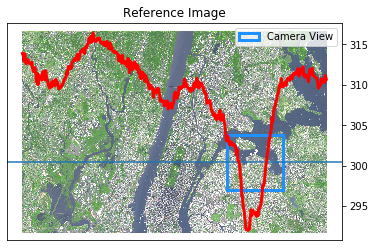

In [14]:
ax = plt.subplot(1,1,1)
plot_ref_img(ax, pos, crop_height=.5)
plot_line_error(pos, ax)

### Searching the database for the captured image

We can replicate this process by searching the entire map for a matching slice. The below graphic uses the same technique as above but we use a heatmap to plot the error. As can be seen, the point corresponding to the smallest error value is exactly the true position of the drone.

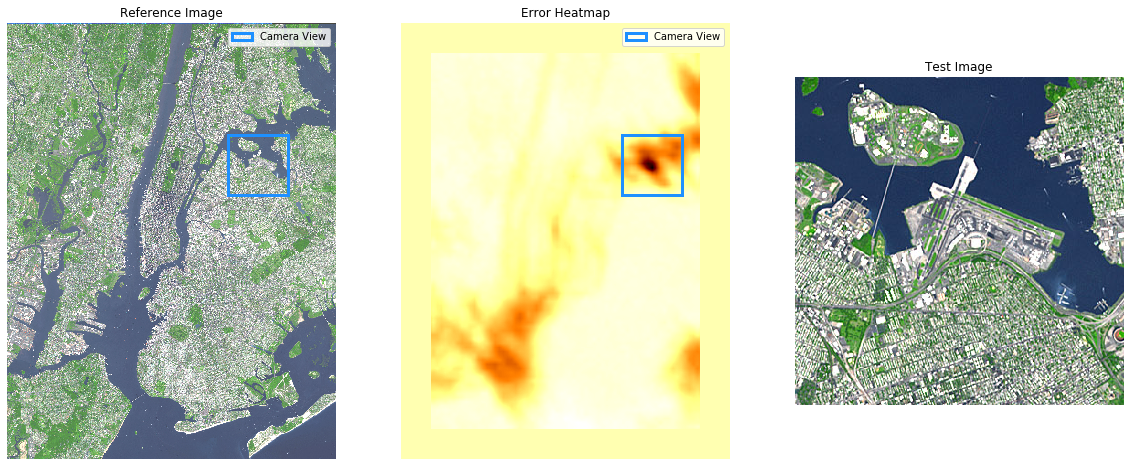

In [15]:
plt.figure(figsize=(20,15))
ax = plt.subplot(1,3,1)
plot_ref_img(ax, pos)

ax = plt.subplot(1,3,2)
plot_ref_img(ax, pos)
plot_heat_map(pos, ax)

img = take_picture(pos)

plt.subplot(1,3,3)
plt.imshow(img)
plt.title("Test Image")
plt.axis('off');

## Synthesis

### Informing the Search Algorithm
As can be seen above, the limitation of these two systems make them less than ideal choices for a military-grade navigation system. Inertial navigation is prone to systematic and random errors that can build up unchecked over large distances. Even small perturbation can multiply over time and cause runaway errors. Image recognition works very well when the sample space is small, but searching every pixel on a large map is not practical nor efficent use of the precious computing power available on smaller drones. Since the image recognition system has high precision in **absolute** location and the IMU can measure very accuractly changes in **relative** position, the systems, in combination, counteract each other's weakness.

To cut down on the search space for the image recognition algorithm, it is useful to have a starting location and search out from there in a radial pattern. We can use the current best estimate for location as the starting point of the search, gathered from the intertial navigation system.

To prevent small errors in the IMU from compounding themselves over time, it is necessary to correct the IMU estimate periodically with more accurate information. When the image recognition system finds a match, it is highly likely that this is the true location, we can shrink our cone of uncertainty that would just continue to grow larger as the drone progresses through space.

### Combining Intertial + Image Recognition

The algorithm we developed works as follows:
![see source at README_files/algo_latex.md](README_files/README_latex.png)

In [16]:
#Build a list of estimated positions
path_est = np.zeros_like(path_true) # Start filling in at index 1
path_est[0] = start_pos

for i in range(1, len(path_true)):
    print("[{}] True Position: {}".format(i, path_true[i]))
    
    # 1. Update the current best estimate, i.e. path_est[i], using data from the onboard sensors
    path_est[i] = path_est[i-1] + deltas_IMU[i-1]
    print("\t{} using data from onboard sensors".format(path_est[i]))
    
    # 2. Take a picture of the ground
    img_test = take_picture(path_true[i].astype(int))
    
    # 3. Search the database for a match, beginning at the current best estimate, i.e. path_est[i]
    err, img_pos_est = search_spiral(path_est[i].astype(int), img_test)
    print("\t{} from image recognition with error of {}".format(img_pos_est, err))

    # 4. Synthesize
    if err < 1.0:
        path_est[i] = img_pos_est
    
    print("[{}] Best Estimate: {}".format(i, path_est[i]))
    print("[{}] Error: {}\n".format(i, euclid_norm(path_true[i,0], path_true[i,1], path_est[i,0], path_est[i,1])))

[1] True Position: [1560.  850.]
	[1556.45263711  850.05803923] using data from onboard sensors
	[1560  850] from image recognition with error of 0.0
[1] Best Estimate: [1560.  850.]
[1] Error: 0.0

[2] True Position: [1620.  850.]
	[1616.34732932  850.13955038] using data from onboard sensors
	[1620  850] from image recognition with error of 0.0
[2] Best Estimate: [1620.  850.]
[2] Error: 0.0

[3] True Position: [1680.  850.]
	[1676.94960956  850.55721225] using data from onboard sensors
	[1680  850] from image recognition with error of 0.0
[3] Best Estimate: [1680.  850.]
[3] Error: 0.0

[4] True Position: [1680.  910.]
	[1676.5667696   910.13756058] using data from onboard sensors
	[1680  910] from image recognition with error of 0.0
[4] Best Estimate: [1680.  910.]
[4] Error: 0.0

[5] True Position: [1680.  970.]
	[1676.45363328  970.69346014] using data from onboard sensors
	[1680  970] from image recognition with error of 0.0
[5] Best Estimate: [1680.  970.]
[5] Error: 0.0

[6] T

Putting it all together, we get:

In [18]:
ani.add_path(path_est, label="With Uwavy Technology", color="blue")
ani.save('README_files/uwavy.mp4')
HTML(ani.toHTML5Video())


If you can't see the video in your browser, [click here](./README_files/uwavy.mp4)

## Conclusion

Our system is fully functional, it will undoubtedly need more testing on real drones. Our plan to perform testing in the field was disrupted by COVID-19, but we believe that this proof of concept is enough to show the viability of our technology. 

Our technology sucessfully fulfills our goals of not needing to communicate with any secondary systems, and performs better than any of the individual subsystems on their own, as we have shown on the demo above. Our technology can provide that reliability. In addition, we believe our technology will perform even faster and more reliably when used on millitary grade processors and hardware. 

We believe that UWavy technology can become a necessary and universal backup to GPS technology as drones become more commonly used in both millitary and private industries. As drones become more prevalent, they will need to be more reliable. Organizations can't make drones part of their necessary processes if they can't be relied upon in every situation. 

### Future Steps
1. Increasing search radius dynamically

This report was prepared by [Jack Alpert](https://github.com/jalpert) and [Fionn Connolly](https://github.com/connollyf) of UWavy Navigation, with work also by Jordan Cohen and [Vincent Lee](https://github.com/Incentivz).

See more at https://github.com/Incentivz/UWavyNavigation